In [21]:
import  numpy as np
import matplotlib.pyplot as plt

from qiskit import BasicAer, Aer, IBMQ
from qiskit import QuantumRegister ,ClassicalRegister,QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.aqua.operators import I, X, Y, Z

from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import QuantumInstance

from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

In [2]:
#Exact solver for reference:
def Exact_solver(qubitOp):
    ex = NumPyEigensolver(qubitOp)
    result = ex.run()
    ref = result['eigenvalues']
    return np.real(ref)

In [11]:
backend = BasicAer.get_backend('qasm_simulator')

In [27]:
def GZB(theta,qc,q0,q1):
    '''
    theta : flaot parameter 
    return quantum gate with the following form :
    
    '''
    qc.cx(q0,q1)
    qc.z(q0)
    qc.cry((np.pi/2-theta)*2,q1,q0)
    qc.cx(q0,q1)


def GZB_mat(theta):
    return np.array([[1,0,0,0],
                     [0,-np.sin(self.theta),np.cos(self.theta),0],
                     [0,np.cos(self.theta),np.sin(self.theta),0],
                     [0,0,0,-1]])

def ansatz_cell(qc,nr_o, nr_e,thetas):
    
    '''
    qc: QuantumCircuit(qo,name='ansatz_cell')
    nr_o: number of orbitals in qo
    nr_e: number of electrons /particles 
    thetas: string of parameters
    '''
    
    it=0
    start=nr_e-1
    limit=nr_o
    while start!=-1:
        cq=start
        tq=start+1
        while tq<limit:
            GZB(thetas[it],qc,cq,tq)
            cq=cq+1
            tq=tq+1
            it=it+1

        start=start-1
        limit=limit-1
    return qc 
    

In [28]:
def var_circ_qiskit(nr_o,nr_e,params):
    
    circ = QuantumCircuit(nr_o)
    for i in range(nr_e):
        circ.x(i)
    circ=ansatz_cell(circ,nr_o, nr_e,thetas=params)
    return circ

In [29]:
# Hidrogen (H_2)

basis='sto3g'
inter_dist=1.4
# Molecule
atoms = 'H .0 .0 .0; H .0 .0 '+str(inter_dist)
driver = PySCFDriver(atoms, unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis,max_memory=None)

#integral h_{lm} , h_{lmpq}
molecule = driver.run()
h1 = molecule.one_body_integrals
h2 = molecule.two_body_integrals
nuclear_repulsion_energy = molecule.nuclear_repulsion_energy

num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2
print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print("# nr. of electrons: {}".format(num_particles))
print("# nr. of spin orbitals: {}".format(num_spin_orbitals))
#print('# one elctron integral:\n',h1)
#print('# two elctron integral:\n',h2)

ferOp = FermionicOperator(h1=h1, h2=h2)
qubitOp = ferOp.mapping(map_type='jordan_wigner')
print(qubitOp)
print(qubitOp.print_details())

weight=[]
pauli=[]
for w,i in qubitOp._paulis:
    weight.append(w)
    pauli.append(i.to_label())
    
nr_o=num_spin_orbitals
nr_e=num_particles
nr_par=(nr_o-nr_e)*nr_e
theta=np.zeros(nr_par)
print(theta)

HF energy: -1.3194643767935124
# nr. of electrons: 2
# nr. of spin orbitals: 4
Representation: paulis, qubits: 4, size: 15
IIII	(-0.8517840380466506+0j)
IIIZ	(0.10053557435398455+0j)
IIZI	(-0.049032364414860446+0j)
IZII	(0.10053557435398452+0j)
ZIII	(-0.04903236441486046+0j)
IIZZ	(0.08678749878785741+0j)
IZIZ	(0.14120468151365045+0j)
XXYY	(0.05575552226867875+0j)
YYYY	(0.05575552226867875+0j)
XXXX	(0.05575552226867875+0j)
YYXX	(0.05575552226867875+0j)
ZIIZ	(0.14254302105653616+0j)
IZZI	(0.14254302105653616+0j)
ZIZI	(0.14891189696596438+0j)
ZZII	(0.08678749878785741+0j)

[0. 0. 0. 0.]


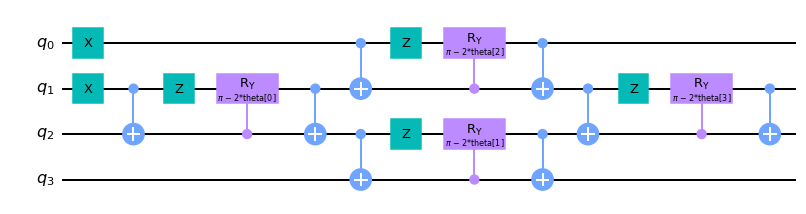

In [30]:
circ=var_circ_qiskit(nr_o,nr_e,params = ParameterVector('theta',length=nr_par))                  
circ.draw('mpl')

In [31]:
def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)
            params.append(parameters)
            deviation.append(std)

In [38]:
seed= 1257
shots=1000
optim = COBYLA(maxiter=1000)

In [39]:
vqe= VQE(operator=qubitOp, var_form=circ, optimizer=optim,callback=store_intermediate_result)

In [40]:
# run quantum algorithm with shots
counts=[]
values=[]
params=[]
deviation=[]


quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
result_shots = vqe.run(quantum_instance)

VQE result: -1.3514357198855433
Exact solver: -1.3934519713739613


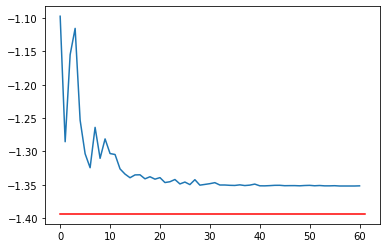

In [41]:
exact=Exact_solver(qubitOp)
print("VQE result:",values[-1])
print("Exact solver:",exact[0])

plt.plot(values)

x=np.linspace(0,len(values))
y=[exact for i in range(len(x))]
plt.plot(x, y, '-r', label='Ideal_value')

plt.show()